In [1]:
import tskit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tskit.__version__

'0.5.5'

In [3]:
ts = tskit.load(
    "/nfs_home/users/osvk/projects/ukb_trees/tsinfer_testing/sample_load_testing/data/chr22/N20000/my.inferred.trees"
)
ts

In [4]:
sites_with_one_mut = np.where(
    np.bincount(ts.mutations_site, minlength=ts.num_sites) == 1
)[0]
sites_pos_with_one_mut = np.take(ts.sites_position, sites_with_one_mut)

In [35]:
# randomly select n query snps without replacement, from the list of sites with single mutation
# for each snp, randomly select a snp <200kb away
# calculate r2 and note time taken
import time

ldcalc = tskit.LdCalculator(ts)
n = 5000
max_dist = 200_000
query_sites = np.random.choice(sites_with_one_mut, size=n, replace=False)
r2 = []
compute_times = []
distances = []
for a in np.sort(query_sites):
    a_pos = ts.sites_position[a]
    ld_range = np.where(
        (sites_pos_with_one_mut >= a_pos - max_dist)
        & (sites_pos_with_one_mut <= a_pos + max_dist)
    )[0]
    rand_ind = np.random.choice(ld_range)
    b = sites_with_one_mut[rand_ind]
    b_pos = sites_pos_with_one_mut[rand_ind]
    start = time.perf_counter()
    r2.append(ldcalc.r2(a, b))
    compute_times.append(time.perf_counter() - start)
    distances.append(abs(b_pos - a_pos))

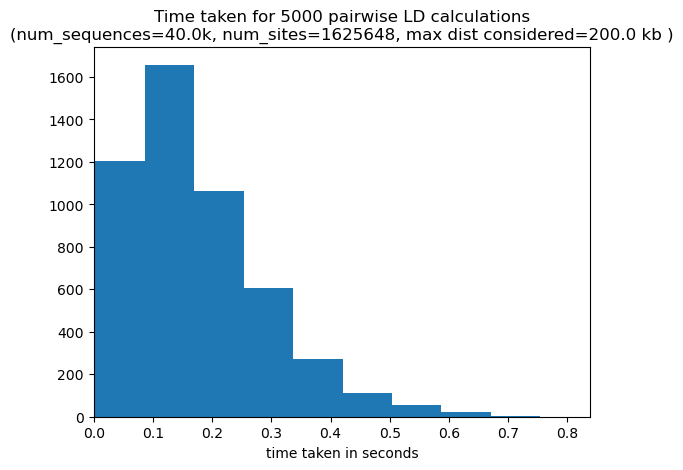

In [36]:
plt.hist(compute_times)
plt.title(
    f"Time taken for {n} pairwise LD calculations\n(num_sequences={ts.num_samples/1_000}k, num_sites={len(sites_with_one_mut)}, max dist considered={max_dist/1_000} kb )"
)
plt.xlabel("time taken in seconds")
plt.xlim(0, max(compute_times))
plt.show()

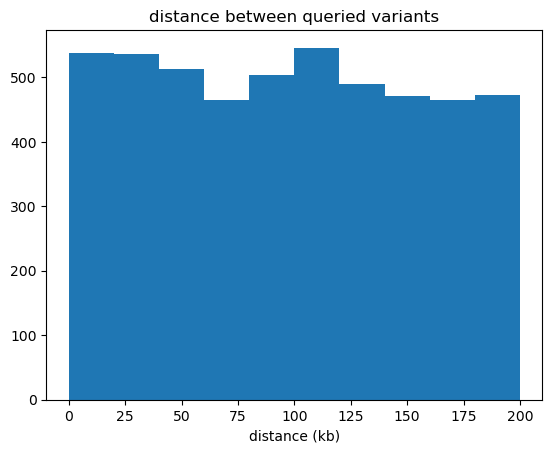

In [37]:
# histogram of distances
plt.hist(np.array(distances) / 1_000)
plt.title(f"distance between queried variants")
plt.xlabel("distance (kb)")
plt.show()

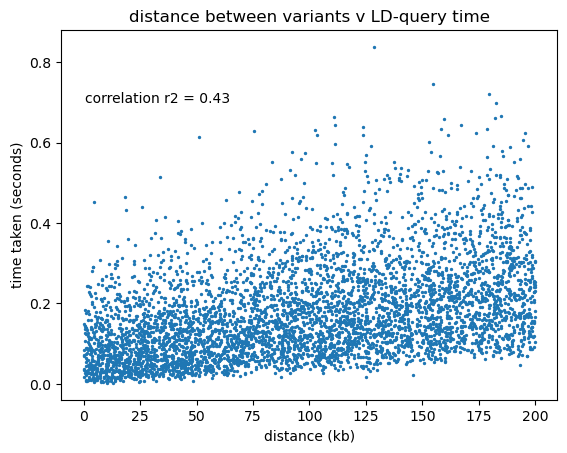

In [44]:
# make a scatterplot of distance vs time
plt.scatter(x=np.array(distances) / 1_000, y=compute_times, s=2)
plt.title(f"distance between variants v LD-query time")
plt.xlabel("distance (kb)")
plt.ylabel("time taken (seconds)")
plt.text(0.3, 0.7, f"correlation r2 = {np.corrcoef(distances, compute_times)[0,1]:.2f}")
plt.show()